In [171]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/boris/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0. Загрузка данных
-----------

Эту часть можно пропустить, результаты будут ниже.

In [172]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('white')
import folder_handling as fh
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2

In [173]:
path = "../../images/color_experiments/experiment_3/no_lightening/"

In [174]:
def load_images(path,type_to_load="train"):
    path_indicators = fh.get_path_contents(path)
    
    data = OrderedDict()
    for pi in path_indicators:
        data[os.path.basename(pi)] = OrderedDict()
        
        for illum in fh.get_path_contents(pi):
            data[os.path.basename(pi)][os.path.basename(illum)] = OrderedDict()
            for gradation in fh.get_path_contents(os.path.join(illum,type_to_load)):
                img = cv2.imread(gradation)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                name = os.path.splitext(os.path.basename(gradation))[0]
                data[os.path.basename(pi)][os.path.basename(illum)][name] = img
                
    return data

In [175]:
data_train = load_images(path)

In [176]:
data_test = load_images(path,type_to_load="test")

1. Тренировочные и тестовые картинки
--------------------

Ниже выведены все картинки, которые были взяты в тренировочный и в тестовый набор. Это такие типы индикаторов, как LEU, NIT, URO, PRO, BLO

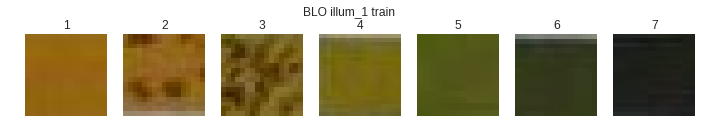

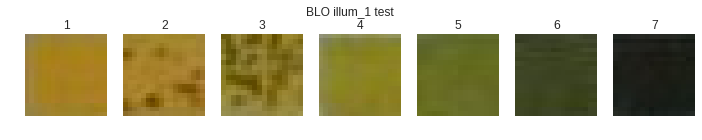

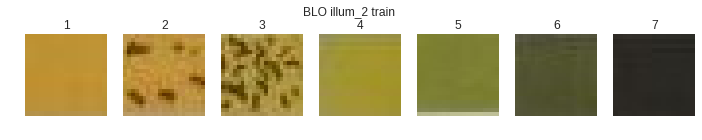

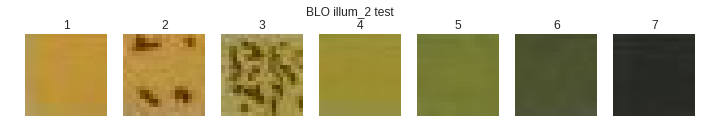

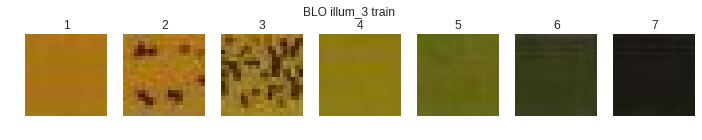

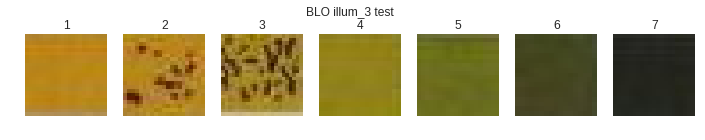

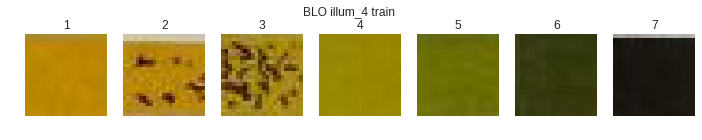

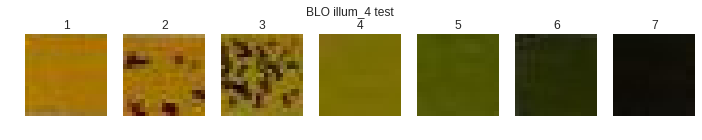

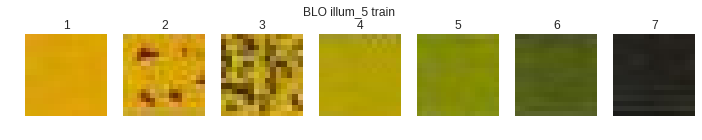

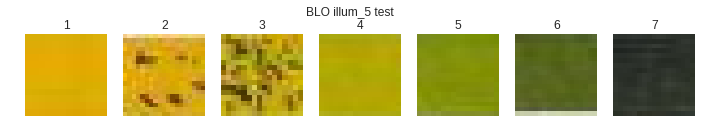

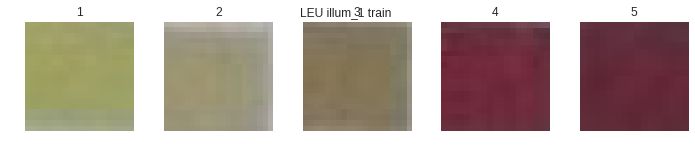

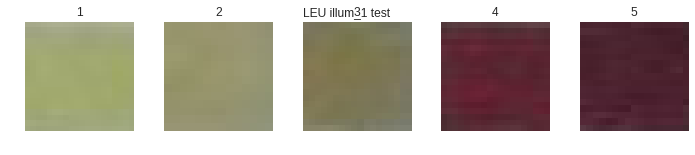

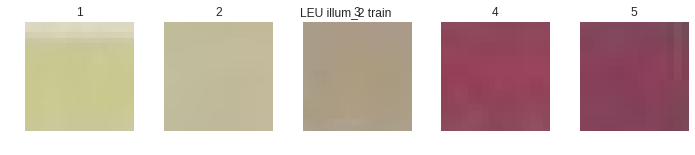

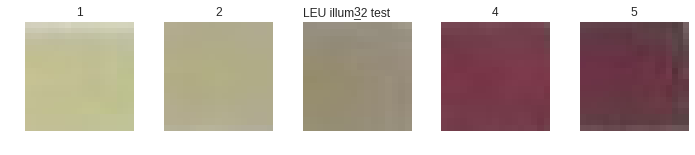

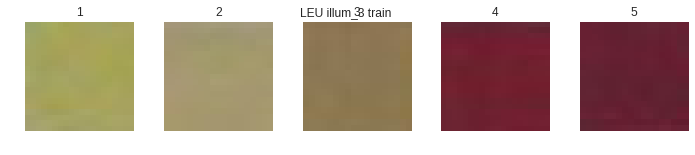

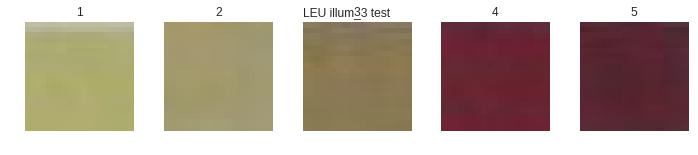

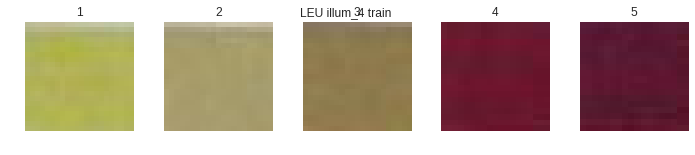

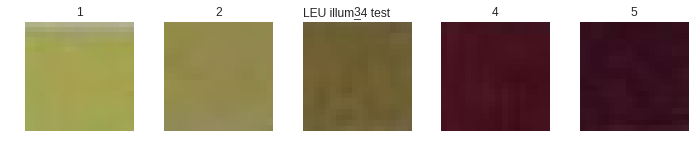

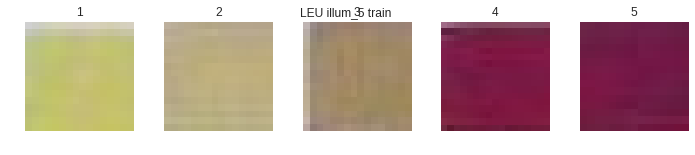

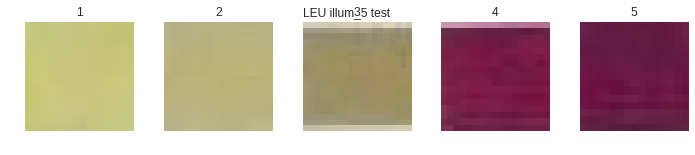

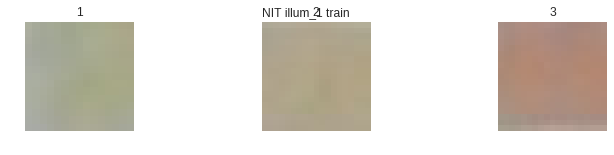

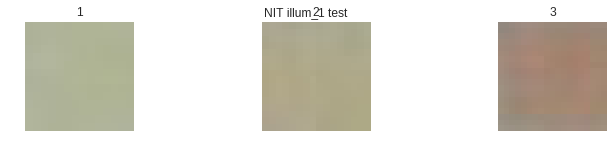

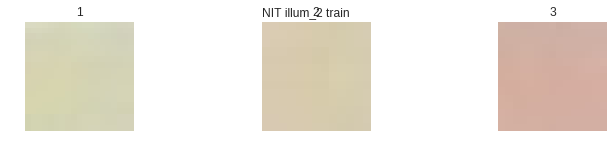

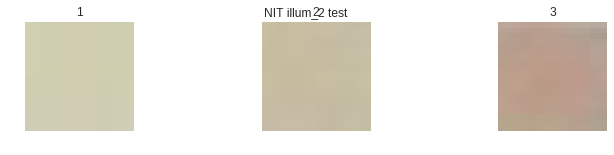

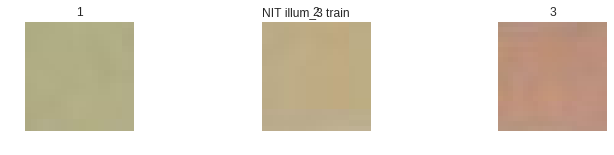

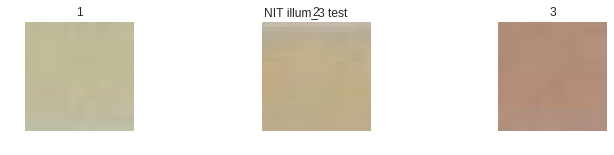

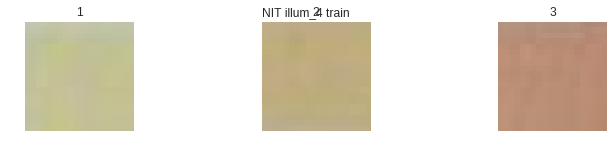

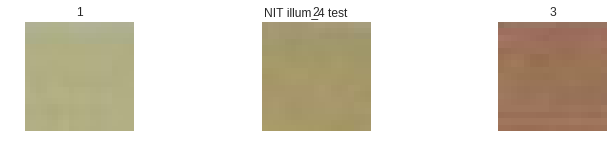

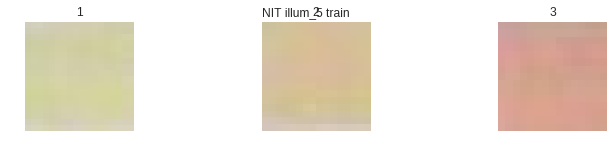

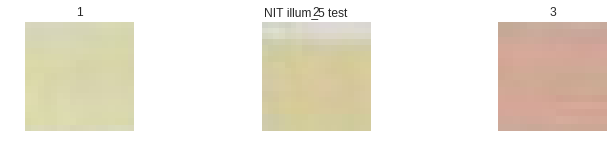

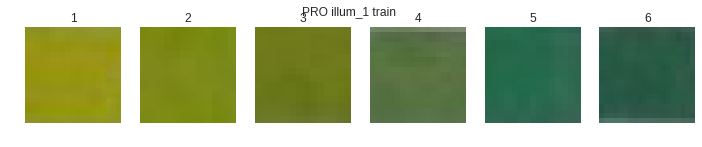

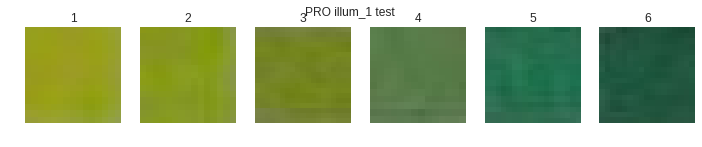

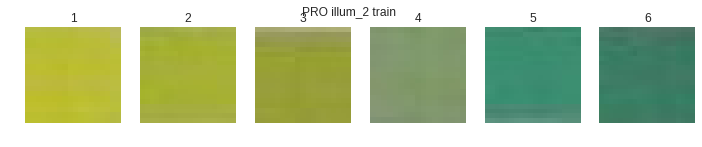

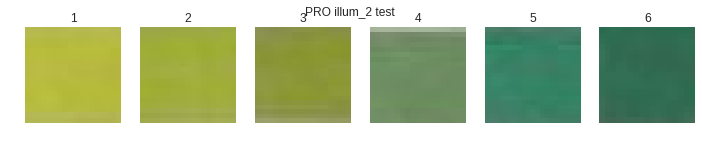

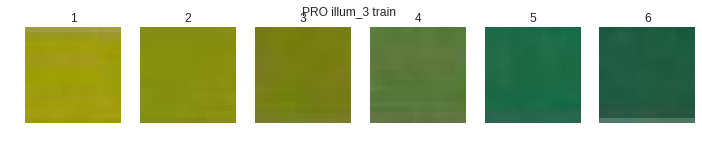

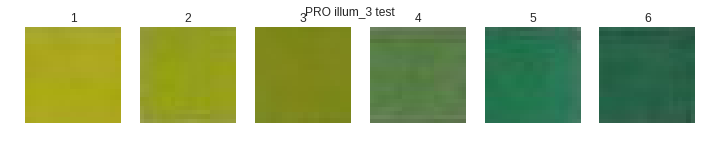

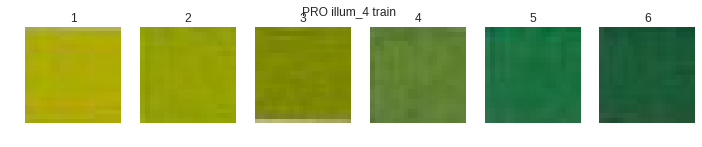

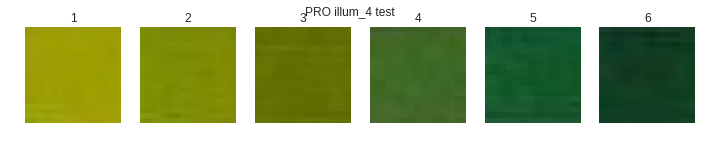

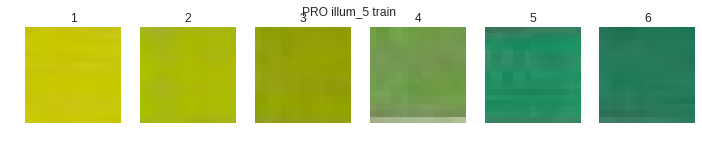

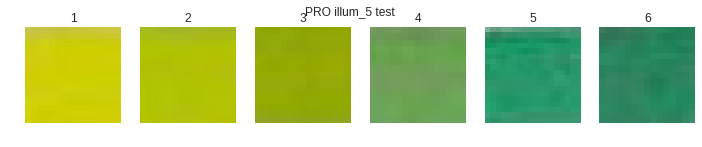

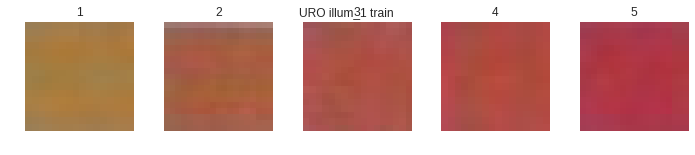

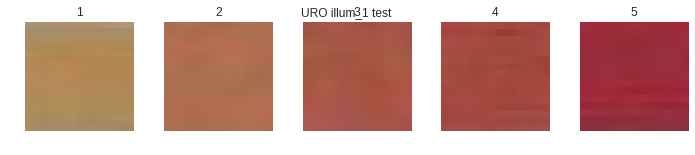

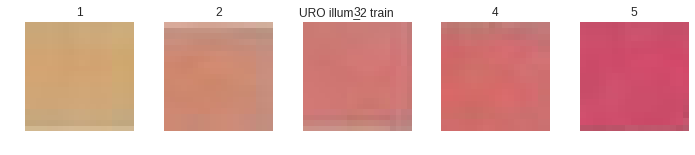

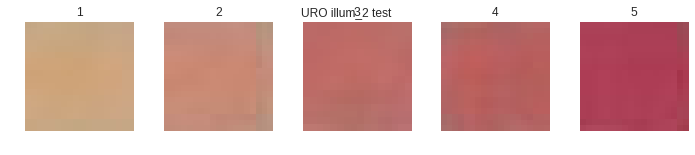

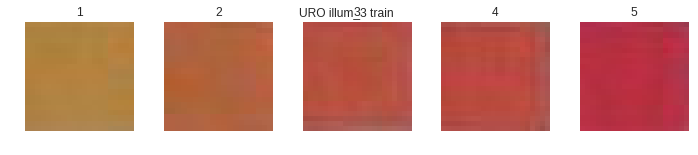

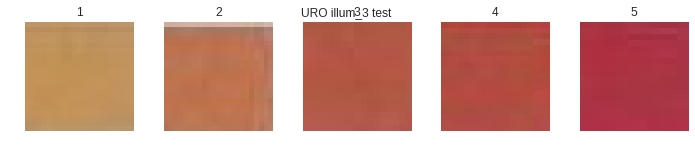

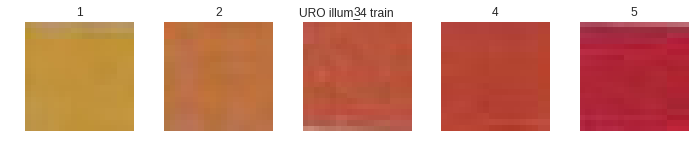

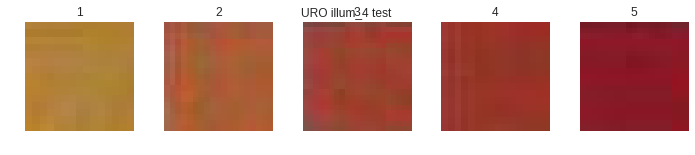

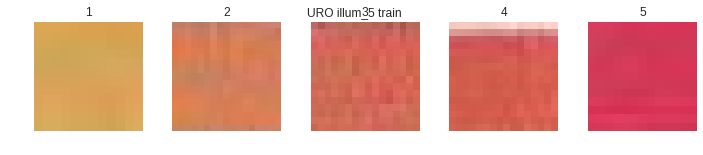

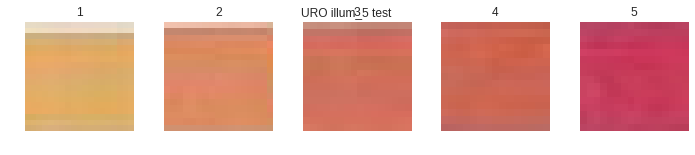

In [177]:
for ind_type in data_train:
    for illumination_name,images in data_train[ind_type].iteritems():
        plt.figure(figsize=(12,2))
        for i,(class_name,img) in enumerate(images.iteritems()):
            plt.subplot(1,len(images),i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
        
        plt.suptitle('{} {} train'.format(ind_type,illumination_name))
        
        plt.figure(figsize=(12,2))
        images_test = data_test[ind_type][illumination_name]
        for i,(class_name,img) in enumerate(images_test.iteritems()):
            plt.subplot(1,len(images_test),i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
        plt.suptitle('{} {} test'.format(ind_type,illumination_name))

## 1.1 Подсчёт статистик

Для каждой освещенности, для каждого типа индикатора и каждой градации индикатора были подсчитаны средние значения и стандартное отклонение. Они ниже приведены на графиках

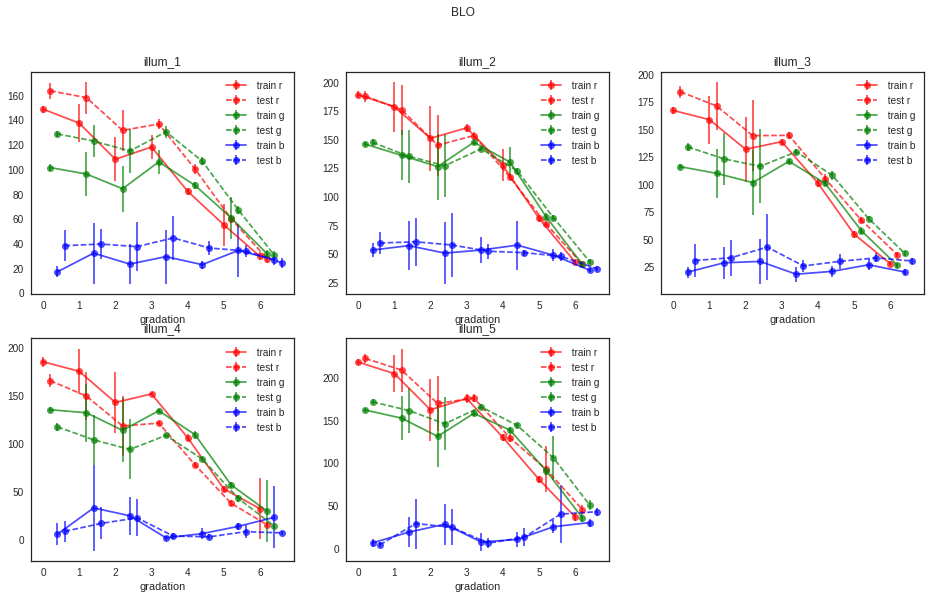

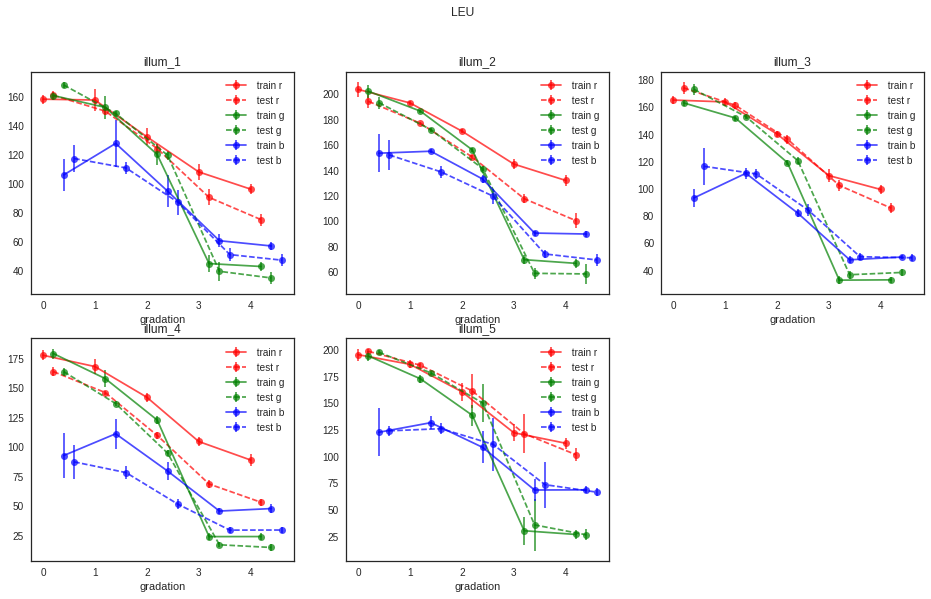

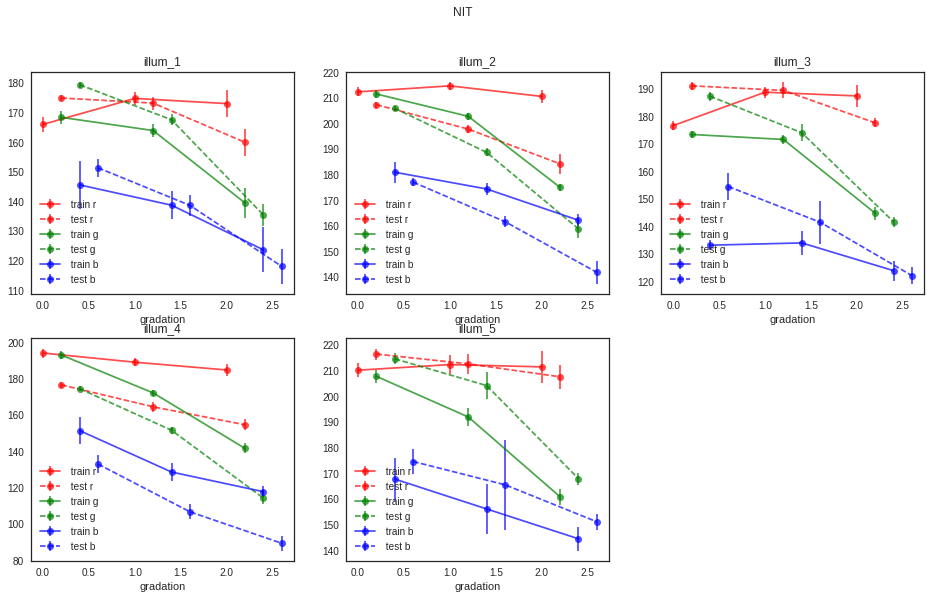

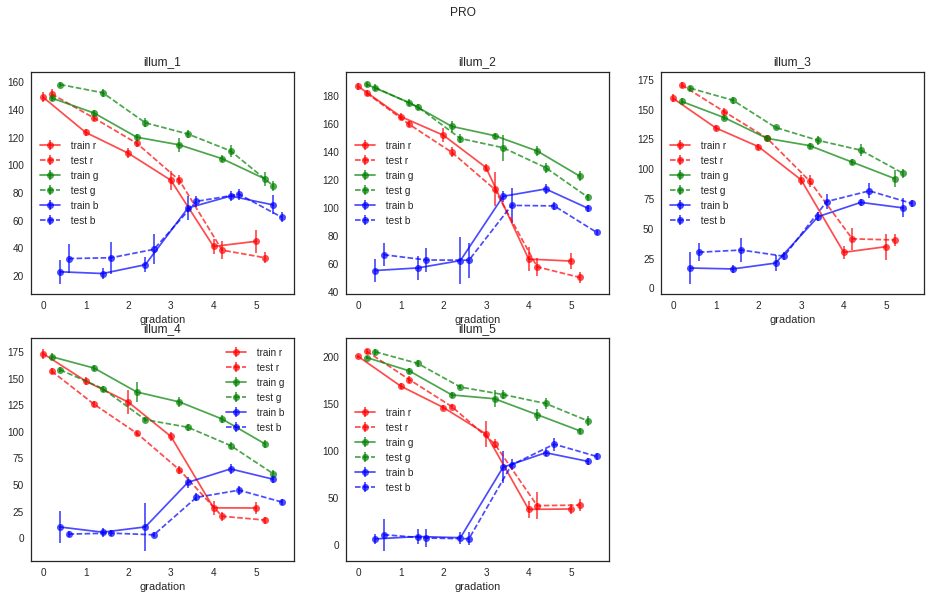

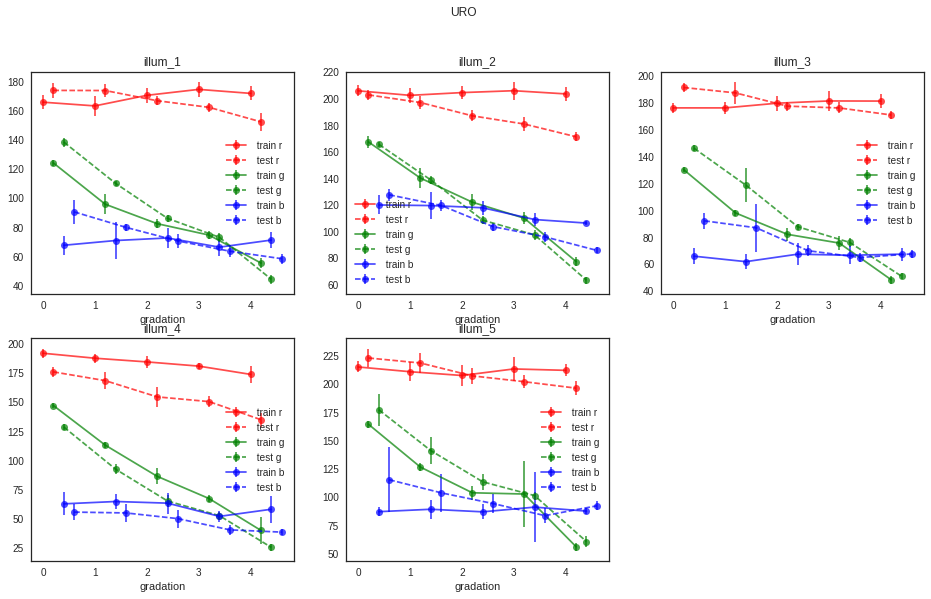

In [178]:
colors = ['r','g','b']
for inds,illums in data_train.iteritems():
    
    plt.figure(figsize=(16,9))
    illums_test = data_test[inds]
    for j,(illum_name,illum) in enumerate(illums.iteritems()):
        illum_test = illums_test[illum_name]
        plt.subplot(2,len(illums)//2 + 1,j+1)
        

        for i in xrange(3):
            values_train = [img.mean(axis=(0,1))[i] for img in illum.values()]
            stds_train = [img.std(axis=(0,1))[i] for img in illum.values()]
            xs_train = np.arange(0.2*i,len(values_train) + 0.2*i,1.)
            
            plt.errorbar(xs_train,values_train,stds_train,fmt='o-',c=colors[i],
                         label=" train {}".format(colors[i]),alpha=0.7)
            
            values_test = [img.mean(axis=(0,1))[i] for img in illum_test.values()]
            stds_test = [img.std(axis=(0,1))[i] for img in illum_test.values()]
            xs_test = np.arange(0.2*(i+1),len(values_test) + 0.2*(i+1),1.)
            
            plt.errorbar(xs_test,values_test,stds_test,fmt='o--',c=colors[i],
                         label=" test {}".format(colors[i]),alpha=0.7)
            
            plt.xlabel('gradation')
        plt.legend()
        plt.title(illum_name)
        
    plt.suptitle(inds)

2. Алгоритм распознавания 
------------------

Была предложена идея распознавать цвет на тестовом изображении с помощью метрического алгоритма одного ближайшего соседа - т.е. искать в тренировочном наборе, относящемся к тому же типу освещенности и индикатору, что и тестовое изображение, ближайшую картинку.

В качестве признаков для обучающего и тестового набора изображений были выбраны:

- средние значения по каналам RGB
- медианные значения по каналам RGB
- средние значения по каналам LAB
- медианные значения по каналам LAB
- некоторые алгоритмы предобработки тестовых и обучающих изображений - Гауссовы фильтры, бокс-фильтры

In [257]:
 def get_distance(point1,point2):
        d = 0.
        for i in xrange(point1.shape[0]):
            d += (point1[i] - point2[i])**2
        return np.sqrt(d)
    
def get_manhattan_distance(point1,point2):
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += np.abs(point1[i] - point2[i])
        
    return d

def get_hsv_distance(point1, point2):
    h1, s1, v1 = point1
    h2, s2, v2 = point2

    dh = min(abs(h2-h1), 360-abs(h2-h1)) / 180.0
    ds = abs(s2-s1)
    dv = abs(v2-v1) / 255.0

    return np.sqrt(dh**2 + ds**2 + dv**2)

def get_RGB_distance(point1,point2):
    d = 0.
    r = 0.5*(point1[0] + point2[0])
    
    
    #coeff = [2 + r/256,4,2 + (255 - r)/256]
    coeff = [2,4,3]
                                
    for i in xrange(point1.shape[0]):
        d += coeff[i]*(point1[i] - point2[i])**2
        
    return np.sqrt(d)


def get_minkowski_distance(point1,point2):
    
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += (np.abs(point1[i] - point2[i]))**minkowski_parameter
    
    return d**(1./minkowski_parameter)

In [258]:
def do_with_image(img):
    img = cv2.blur(img,(3,3))
    return cv2.cvtColor(img,cv2.COLOR_RGB2LAB)

In [259]:
def one_nearest_neighbor(data_train,indicator_type,
                         illumination_name,test_img,verbose=False,
                         applied_statistic=np.mean, do_with_image=None,
                         get_distance=get_distance,
                         return_probabilities=False):
    
    if do_with_image is not None:
        test_img = do_with_image(test_img)
   
    point_test = applied_statistic(test_img,axis=(0,1))

    predicted_class = None
    min_dist = None

    distances = []
    for class_name,trained_img in data_train[indicator_type][illumination_name].iteritems():
        
        if do_with_image is not None:
            trained_img = do_with_image(trained_img)
        point_train = applied_statistic(trained_img,axis=(0,1))

        dist = get_distance(point_test,point_train)
        
        if min_dist is None:
            min_dist = dist
            
        if dist <= min_dist:
            min_dist = dist
            predicted_class = class_name

        if verbose:
            print "Current train class:",class_name
            print "Current distance:",dist

            print "Minimal distance is",min_dist
            print "Current predicted class is",predicted_class
            
            print "Test point coordinates",point_test
            print "Train point coordinates",point_train
            print
        
        distances.append(dist)
    
    if return_probabilities:
        d = np.array(distances)/10.
        probabilities = np.exp(-(d - np.max(d)))/np.sum(np.exp(-(d - np.max(d))))
        return predicted_class,probabilities
    
    return predicted_class

In [260]:
indicator_type = 'BLO'
illumination_name = 'illum_3'
true_class = '3'
test_img = data_test[indicator_type][illumination_name][true_class]

In [261]:
mistakes_strict = []
mistakes_soft = []
all_results_strict = []
all_results_soft = []
prob_mistakes = []
for indicator_type in data_test:
    
#     if indicator_type == 'BLO':
#         continue 
        
    for illumination in data_test[indicator_type]:
        for true_class in data_test[indicator_type][illumination]:
            test_img = data_test[indicator_type][illumination][true_class]
            pred_val,p = one_nearest_neighbor(data_train,indicator_type=indicator_type,
                                illumination_name=illumination,
                                test_img=test_img,verbose=False,
                                applied_statistic=np.mean,
                                do_with_image=do_with_image,
                                get_distance=get_manhattan_distance,
                                return_probabilities=True)
#             print "\n==========="
#             print indicator_type, illumination
#             print "True class is", true_class
#             print "Predicted class is",pred_val
#             print "true_class == pred_val:", true_class == pred_val

            all_results_strict.append(true_class == pred_val)
    
            all_results_soft.append(np.abs(int(true_class) - int(pred_val)) <= 1)

   
            if pred_val != true_class:
                mistakes_strict.append((indicator_type,illumination,"True class :{}".format(true_class),
                             "Predicted class :{}".format(pred_val)))
                prob_mistakes.append(p)
                if abs(int(pred_val) - int(true_class)) > 1:
                    mistakes_soft.append((indicator_type,illumination,"True class :{}".format(true_class),
                             "Predicted class :{}".format(pred_val)))
#                 print "\n added to mistakes_strict"
                
#             print"\n\n\n"

In [262]:
strict_acc = np.sum(all_results_strict)/float(len(all_results_strict))
print "Точность в предсказании верного класса\n {} %".format(round(strict_acc*100,1))

soft_acc = np.sum(all_results_soft)/float(len(all_results_soft))
print "Точность в предсказании класса с отклонением не более 1\n {} %".format(round(soft_acc*100,1))

Точность в предсказании верного класса
 76.9 %
Точность в предсказании класса с отклонением не более 1
 99.2 %


- Переход в HSV и евклидова метрика с подсчётом среднего в качестве признаков: 
   - Точность в предсказании верного класса
        73.1 %
        Точность в предсказании класса с отклонением не более 1
        96.2 %
         
- Переход в HSV и манхеттенское расстояние и среднее:
    - Точность в предсказании верного класса
         76.9 %
        Точность в предсказании класса с отклонением не более 1
         96.9 %
- Переход в HSV, manhattan, median: 
    - Точность в предсказании верного класса
         76.2 %
        Точность в предсказании класса с отклонением не более 1
         97.7 %
- LAB, Euclidean, median: 
    - Точность в предсказании верного класса
 71.5 %
    Точность в предсказании класса с отклонением не более 1
    98.5 %
- LAB, Euclidean, mean:
    - Точность в предсказании верного класса
 70.8 %
    Точность в предсказании класса с отклонением не более 1
    99.2 %
    
- LAB, manhattan, mean:
    - Точность в предсказании верного класса
 76.2 %
    Точность в предсказании класса с отклонением не более 1
     99.2 %
- LAB, manhattan, median:
    - Точность в предсказании верного класса
 74.6 %
    Точность в предсказании класса с отклонением не более 1
     98.5 %
- XYZ, manhattan or Euclidean, mean: 
    - Плохо - 60 %, 95%

**Промежуточный вывод:**

Пока, для всех алгоритмов полная точность составляет порядка 72 процентов попадания в ту же градацию. В большинстве случаев алгоритм ошибается на одну градацию (как в большую так и в меньшую стороны).


**Ниже выведены ошибочные варианты**:
За исключением индикатора "BLO", все остальные ошибки выглядят вразумительно.

In [263]:
def plot_mistakes(mistakes_strict):
    for item in mistakes_strict:
        plt.figure(figsize=(10,3))
        ind_type, illum, true_class, predicted_class = [x.split(':')[-1] for x  in item]
        img_train_true = data_train[ind_type][illum][true_class]
        img_train_chosen = data_train[ind_type][illum][predicted_class]
        img_test = data_test[ind_type][illum][true_class]

        plt.subplot(1,3,1)
        plt.imshow(img_test)
        plt.title('test image')

        plt.subplot(1,3,2)
        plt.imshow(img_train_chosen)
        plt.title('predicted image, class {}'.format(predicted_class))

        plt.subplot(1,3,3)
        plt.imshow(img_train_true)
        plt.title('true test image, class {}'.format(true_class))

        plt.suptitle(ind_type)
        plt.tight_layout()

In [264]:
"""for item,p in zip(mistakes_strict,prob_mistakes):
        plt.figure(figsize=(10,3))
        ind_type, illum, true_class, predicted_class = [x.split(':')[-1] for x  in item]
        img_train_true = data_train[ind_type][illum][true_class]
        img_train_chosen = data_train[ind_type][illum][predicted_class]
        img_test = data_test[ind_type][illum][true_class]

        plt.subplot(1,4,1)
        plt.imshow(img_test)
        plt.title('test image')

        plt.subplot(1,4,2)
        plt.imshow(img_train_chosen)
        plt.title('predicted image, class {}'.format(predicted_class))

        plt.subplot(1,4,3)
        plt.imshow(img_train_true)
        plt.title('true test image, class {}'.format(true_class))

        plt.subplot(1,4,4)
        plt.plot(range(1,len(data_train[ind_type][illum])+1),-10*np.log(p),'o-')
        plt.xlabel('class')
        plt.ylabel('probability')
        
        plt.suptitle(ind_type)
        plt.tight_layout()"""
pass

In [265]:
#plot_mistakes(mistakes_soft)

In [266]:
for item in mistakes_strict:
    ind_type, illum, true_class, _ = item
#    print ind_type, illum,true_class,_
    test_img = data_test[ind_type][illum][true_class.split(':')[-1]]
    pred_val = one_nearest_neighbor(data_train,indicator_type=ind_type,
                                illumination_name=illum,
                                test_img=test_img, verbose=False)
    
#     print "\n==========="
#     print "True class is", true_class
#     print "Predicted class is",pred_val
    
#     print "true_class == pred_val:", true_class == pred_val
    
#     print"\n\n\n"
    
   

# Попробуем сделать перебор по сетке

In [267]:
def get_accuracy(applied_statistic,do_with_image,get_distance):

    all_results_strict = []
    all_results_soft = []
    prob_mistakes = []
    for indicator_type in data_test:

        for illumination in data_test[indicator_type]:
            for true_class in data_test[indicator_type][illumination]:
                test_img = data_test[indicator_type][illumination][true_class]
                pred_val = one_nearest_neighbor(data_train,indicator_type=indicator_type,
                                    illumination_name=illumination,
                                    test_img=test_img,verbose=False,
                                    applied_statistic=applied_statistic,
                                    do_with_image=do_with_image,
                                    get_distance=get_distance,
                                    return_probabilities=False)

                all_results_strict.append(true_class == pred_val)

                all_results_soft.append(np.abs(int(true_class) - int(pred_val)) <= 1)
                
    strict_acc = np.sum(all_results_strict)/float(len(all_results_strict))

    soft_acc = np.sum(all_results_soft)/float(len(all_results_soft))

    return strict_acc, soft_acc

In [268]:
get_minkowski_distance(np.array([1,2,3]),np.array([3,4,2]))

2.571281590658235

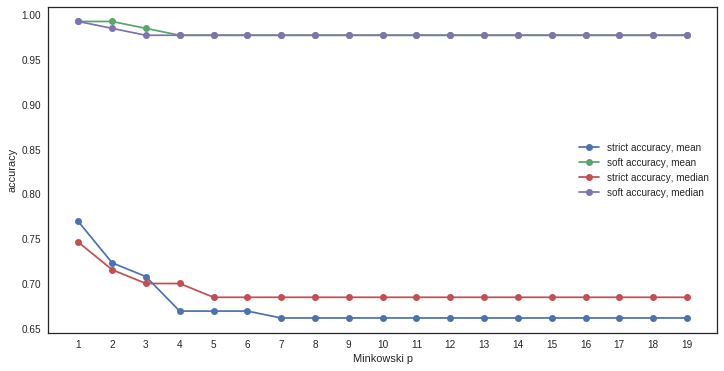

In [279]:

plt.figure(figsize=(12,6))
names = ['mean','median']
for i,applied_statistic in enumerate([np.mean,np.median]):
    
    strict_accs = []
    soft_accs = []
    for p in xrange(1,20):
        minkowski_parameter = p
        strict_acc, soft_acc = get_accuracy(applied_statistic=applied_statistic,
                     do_with_image=do_with_image,
                     get_distance = get_minkowski_distance)

        strict_accs.append(strict_acc)
        soft_accs.append(soft_acc)
    
    plt.plot(range(1,20),strict_accs,'o-',label='strict accuracy, {}'.format(names[i]))
    plt.plot(range(1,20),soft_accs,'o-',label='soft accuracy, {}'.format(names[i]))
    plt.xticks(range(1,20));
    plt.xlabel('Minkowski p')
    plt.ylabel('accuracy')
plt.legend()

# Отдельно разберёмся с одним классом

In [62]:
mistakes_strict = []
all_results = []

indicator_type = 'PRO'
for illumination in data_test[indicator_type]:
    for true_class in data_test[indicator_type][illumination]:
        test_img = data_test[indicator_type][illumination][true_class]
        pred_val = one_nearest_neighbor(data_train,indicator_type=indicator_type,
                                illumination_name=illumination,
                                test_img=test_img,verbose=False,#True,
                                applied_statistic=np.median,
                                do_with_image=do_with_image,
                                get_distance=get_manhattan_distance)
        
#         print "\n==========="
#         print indicator_type, illumination
#         print "True class is", true_class
#         print "Predicted class is",pred_val
#         print "true_class == pred_val:", true_class == pred_val

        all_results.append(true_class == pred_val)

   
        if pred_val != true_class:
            mistakes_strict.append((indicator_type,illumination,"True class :{}".format(true_class),
                             "Predicted class: {}".format(pred_val)))
#             print "\n added to mistakes_strict"
                
#         print"\n\n\n"

In [63]:
mistakes_strict

[('PRO', 'illum_1', 'True class :2', 'Predicted class: 1'),
 ('PRO', 'illum_2', 'True class :5', 'Predicted class: 6'),
 ('PRO', 'illum_3', 'True class :2', 'Predicted class: 1'),
 ('PRO', 'illum_4', 'True class :1', 'Predicted class: 2'),
 ('PRO', 'illum_4', 'True class :2', 'Predicted class: 3'),
 ('PRO', 'illum_4', 'True class :3', 'Predicted class: 4'),
 ('PRO', 'illum_4', 'True class :4', 'Predicted class: 5'),
 ('PRO', 'illum_4', 'True class :5', 'Predicted class: 6'),
 ('PRO', 'illum_5', 'True class :6', 'Predicted class: 5')]

In [64]:
np.sum(all_results)/float(len(all_results))

0.69999999999999996

In [280]:
mistakes_strict = []

for indicator_type in data_test:
    
    #if indicator_type == 'BLO':
    #    continue 
    all_results_strict = []
    all_results_soft = []
    for illumination in data_test[indicator_type]:
        for true_class in data_test[indicator_type][illumination]:
            test_img = data_test[indicator_type][illumination][true_class]
            
            pred_val = one_nearest_neighbor(data_train,indicator_type=indicator_type,
                                illumination_name=illumination,
                                test_img=test_img,verbose=False,#True,
                                applied_statistic=np.median,
                                do_with_image=do_with_image,
                                get_distance=get_manhattan_distance)
        
#             print "\n==========="
#             print indicator_type, illumination
#             print "True class is", true_class
#             print "Predicted class is",pred_val

#             print "true_class == pred_val:", true_class == pred_val

            all_results_strict.append(true_class == pred_val)
            all_results_soft.append(abs(int(true_class)-int(pred_val))<=1)
   
#             if pred_val != true_class:
#                 mistakes_strict.append((indicator_type,illumination,true_class,pred_val))
#                 print "\n added to mistakes_strict"
                
#             print"\n"
    
    print '\n+++++++++++++++++++'
    print indicator_type
    
    print "strict accuracy", np.sum(all_results_strict)/float(len(all_results_strict))
    print "soft accuracy",np.sum(all_results_soft)/float(len(all_results_soft))


+++++++++++++++++++
BLO
strict accuracy 0.742857142857
soft accuracy 0.971428571429

+++++++++++++++++++
LEU
strict accuracy 0.76
soft accuracy 1.0

+++++++++++++++++++
NIT
strict accuracy 0.733333333333
soft accuracy 1.0

+++++++++++++++++++
PRO
strict accuracy 0.7
soft accuracy 1.0

+++++++++++++++++++
URO
strict accuracy 0.8
soft accuracy 1.0
